# **‘Dataset’**

## Part 1: Dataset Import script:

Load the protein sequence data set in the .fasta format. The numbers in the square brackets correspond to class labels.
Hint: Search for the python package ‘biopython’

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install biopython

In [3]:
##### Imports #####
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import numpy as np
import pandas as pd
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from Bio import Align

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


### **Data Import Function:** In this function we import the .fasta file using SeqIO module of the Bio package.

In [4]:
### Function to import fasta file
def get_fasta_file():
  fasta_file_path = "/content/drive/MyDrive/Colab Notebooks/LSD/sequences.fasta"
  sequences = SeqIO.parse(fasta_file_path, "fasta")
  return sequences

In [5]:
### Get FASTA file
sequences = get_fasta_file()

### Iterate over first 5 sequences and print information
i = 1
for seq_record in sequences:
    if i > 5:
      break
    print("ID:", seq_record.id)
    print("Description:", seq_record.description)
    print("Sequence:", seq_record.seq)
    print("Length:", len(seq_record))
    print("--------------------------------------")
    i += 1

ID: Q5AV81
Description: Q5AV81 [16491]
Sequence: MVRIFITGSSDGIGQAAAKVLSEQGHSVVLHARNADRAASAQEAVPGAEAVLVGDLSSIAETKALAEEANKLPPFDTVIHNAGIGYGATASQEITADKISAVFAVNTLAPYILTCLMHKPKARLLYMSSDSHYGGDESLRNITQSHSYGNTKLHDVMLANAFSRRWGNAIQVVSMHPGWVRTKMGGVMAPGALDRPARVLADWAIGKGDLARLKSGTFFTTSGPESAHPGADNVQKQEELLRICKEVSGVGVPGG
Length: 255
--------------------------------------
ID: B1Y654
Description: B1Y654 [16491]
Sequence: MTHALDTLALNQLFTEARTHNAWRDEPVAPELLRQLHELAKWGPTAMNCCPLRVRFIVGAEARARLLPLMSEGNRAKTAAAPVIAILGRDVDFHQHMPTLAPHMAGARERFADQPAQREAMSQLNGALEAGYFILAARALGLDCGPMGGFDAAAVDAEFWAGTAVRSMIVCNLGHGDPAGLRPRAPRLDFDTACAVL
Length: 197
--------------------------------------
ID: P83288
Description: P83288 [90729]
Sequence: MKIVLVFVCTLYLAQATYLSEQDVNEVSEFLEALDQANEAASEMVEAAETEEARDWECLPLHSSCDNDCVCCKNHHCHCPYSNVSKLEKWLPEWAKIPDALKRCSCQRNDKDGKINTCDKYKN
Length: 123
--------------------------------------
ID: P39901
Description: P39901 [3677]
Sequence: MIALSVCWQIVRYLCRIRQMXGLNAIEHSNYLRNYMGHLRQKLEQDPARPRHFITETGIGYRFML
Length: 

## Part 2: Smith-Waterman Algorithm for Alignments

### **Smith-Waterman Alignment:**
This function is used to get the best alignment between two sequences. First we call the pairwise2.align.localms function which performs the pairwise sequence alignment using a dynamic programming algorithm.

When calling this function, we specify the match score and gap penalties. The match score indicates the compatibility between an alignment of two characters in the sequences. Highly compatible characters should be given positive scores, and incompatible ones should be given negative scores or 0. The gap penalties should be negative.

Then we get the alignment for first two sequences of the dataset and for a nice printout, we use the format_alignment method.



In [6]:
### Calculating Smith-Waterman alignment
def smith_waterman_alignment(seq1, seq2, match_score=2, mismatch_penalty=-2, gap_open_penalty=-1, gap_extend_penalty=-0.5):

    # The pairwise2.align.localms() function for local sequence alignment
    alignments = pairwise2.align.localms(seq1, seq2, match_score, mismatch_penalty, gap_open_penalty, gap_extend_penalty)
    best_alignment = max(alignments, key = lambda x: x.score)

    return best_alignment       #Return the best alignment

In [7]:
### SeqIO.parse() function to read the FASTA file
sequences = get_fasta_file()

sequence1 = next(sequences, None)
sequence2 = next(sequences, None)

print("First sequence: ", sequence1.id, ": ", sequence1.seq)
print("Second sequence: ", sequence2.id, ": ", sequence2.seq)

### Get and print the alignment
alignment = smith_waterman_alignment(sequence1.seq,sequence2.seq)
print(format_alignment(*alignment))

First sequence:  Q5AV81 :  MVRIFITGSSDGIGQAAAKVLSEQGHSVVLHARNADRAASAQEAVPGAEAVLVGDLSSIAETKALAEEANKLPPFDTVIHNAGIGYGATASQEITADKISAVFAVNTLAPYILTCLMHKPKARLLYMSSDSHYGGDESLRNITQSHSYGNTKLHDVMLANAFSRRWGNAIQVVSMHPGWVRTKMGGVMAPGALDRPARVLADWAIGKGDLARLKSGTFFTTSGPESAHPGADNVQKQEELLRICKEVSGVGVPGG
Second sequence:  B1Y654 :  MTHALDTLALNQLFTEARTHNAWRDEPVAPELLRQLHELAKWGPTAMNCCPLRVRFIVGAEARARLLPLMSEGNRAKTAAAPVIAILGRDVDFHQHMPTLAPHMAGARERFADQPAQREAMSQLNGALEAGYFILAARALGLDCGPMGGFDAAAVDAEFWAGTAVRSMIVCNLGHGDPAGLRPRAPRLDFDTACAVL
45 VPGAEAV---LVGDL---SSIAE-----TKALAEEANKLPPFDTVIHNAGI-G
   | ||||    |   |   |   |     | | |  |   |    ||  | | |
58 V-GAEA-RARL---LPLMS---EGNRAKT-A-A--A---P----VI--A-ILG
  Score=13.5



# **‘Embedding’**



## Part 1: Construct a pair-wise similarity matrix using the Smith-Waterman alignment

### **Smith-Waterman alignment for Best Alignment Score:**
Here, we create another implementation of the Smith Watermann Alignment to get the best alignment score instead of just the alignment. This score will be further used to create a Similarity Matrix. We use the aligner from **Align.PairwiseAligner** which will calculate the score for the best alignment of the sequences.

In [8]:
### Calculating Smith-Waterman alignment score, it returns the best alignment
def smith_waterman_alignment_score(seq1, seq2, match_score=8, mismatch_penalty=-4, gap_open_penalty=-1, gap_extend_penalty=-0.5):

    aligner = Align.PairwiseAligner(match_score=match_score,mismatch_score=mismatch_penalty,gap_score=gap_open_penalty)
    aligner.mode = "local"
    score = aligner.score(seq1,seq2)
    return score

### **Calculating Similarity Matrix:**
In this function we calculate the similarity matrix for the sequences. The parameter num_sequences stands for the number of sequences we want to compare and get the similarity matrix for. We first initialize the matrix with zeros, and then inside a double loop, we get the best alignment score of two sequences. Then we store that value in the similarity matrix and since we assume symmetry, we fill the upper as well as lower triangular part of the matrix with the same value.

In [16]:
### Pair-wise similarity matrix
def get_similarity_matrix(sequences, num_sequences):
  k=1
  similarity_matrix = np.zeros((num_sequences,num_sequences))
  for i in tqdm(range(num_sequences)):
      for j in range(i, num_sequences):
          seq1 = sequences[i].seq
          seq2 = sequences[j].seq
          alignment_score = smith_waterman_alignment_score(seq1, seq2)

          # Assume symmetry
          similarity_matrix[i][j] = similarity_matrix[j][i] = alignment_score
      #print("\n",k)
      k+=1

  return similarity_matrix

### **Printing the Similarity Matrix:**
Here, we call the functions to create the similiarity matrix using the Smith Waterman alignment scores.

We then call the function to get the similarity matrix and print it.

In [62]:
### Importing the FASTA file
fasta_iterator = get_fasta_file()
sequences = list(fasta_iterator)

### Taking 5000 sequences
seq5k_asc = sequences
print("Taking ", len(seq5k_asc), "Sequences")
num_sequences = len(seq5k_asc)

### Pair-wise similarity matrix
similarity_matrix = get_similarity_matrix(seq5k_asc, num_sequences)

## Print the similarity matrix
print(similarity_matrix)

### Save similarity Matrix
#pd.to_csv('similaritymatrix.csv')

Taking  5000 Sequences


100%|██████████| 5000/5000 [1:30:26<00:00,  1.09s/it]

[[2040.  403.  255. ...  377.  460.  211.]
 [ 403. 1576.  228. ...  339.  335.  160.]
 [ 255.  228.  984. ...  212.  245.  145.]
 ...
 [ 377.  339.  212. ... 1760.  447.  198.]
 [ 460.  335.  245. ...  447. 4048.  189.]
 [ 211.  160.  145. ...  198.  189.  704.]]


## Part 2: Implement an embedding into a 100-dimensional euclidean vector space

### **Embedding into a 100-d space:**

After getting the Similarity Matrix, we get the first k-eigenvectors and eigenvalues(in this case first 100). So, what do the first k-eigenvectors stand for? Like all clustering algorithms, we must choose the number of clusters for our algorithm to find.

Then, we do a Matrix Multiplication of the similarity matrix and the computed top k-eigenvectors. Due to this, the similarity matrix gets transformed into the 100d space defined by the calculated k-eigenvectors. Finally we return this result as an embedding_matrix.


In [21]:
### Function to do embedding
def get_embedding(similarity_matrix, num_dimensions=100):

    ### Compute Eigenvalues and Eigenvectors of similarity matrix
    eigenvalues, eigenvectors = np.linalg.eigh(similarity_matrix)

    ### Sort Eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_eigenvalues = eigenvalues[sorted_indices][:num_dimensions]

    ### Extract Eigenvectors
    top_eigenvectors = eigenvectors[:, sorted_indices][:, :num_dimensions]

    ### Form Embedding Matrix using Dot Product
    embedding_matrix = np.dot(similarity_matrix, top_eigenvectors)

    return embedding_matrix

In [22]:
### Get the saved similarity Matrix
# similarity_matrix = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LSD/similaritymatrix.csv')
# similarity_matrix.drop('ID', axis=1, inplace=True)
# similarity_matrix.shape

(5000, 5000)

In [23]:
### Get the embeddings
embedding_matrix = get_embedding(similarity_matrix)
print(embedding_matrix)
print(embedding_matrix.shape)

[[-2.93883615e+04 -3.29626104e+03  7.17196352e+02 ... -1.03197670e+02
  -1.62011100e+02  1.08589797e+02]
 [-2.37249012e+04 -3.56621220e+03  7.46077533e+02 ...  1.54662487e+02
  -8.18544781e+01  2.09516879e+02]
 [-1.52843552e+04 -3.36836786e+03 -9.83571454e+01 ... -6.67641691e+01
   7.40287849e+00 -2.00080676e+02]
 ...
 [-2.54709940e+04 -3.61213102e+03 -2.03384957e+02 ... -1.29373725e+02
  -2.78114169e+02 -9.56546676e+02]
 [-3.94435869e+04  2.08023998e+03  2.14643453e+03 ... -1.11525455e+02
  -1.31561481e+02  8.54435906e+00]
 [-1.28011048e+04 -3.06103475e+03  5.32324369e+02 ... -1.47949545e+01
   5.63557171e+01 -4.18113871e+01]]
(5000, 100)


# **Exercise3: 'Evaluation'**

Evaluating the resulting embedding using ‘Clustering’

## Part 1: Clustering the data, evaluation using Normalise Mutual Information (NMI) visualisation by employing the proximity matrix. Implemeted method: Affinity Propagation.

### **Normalized Mutual Information:**

Normalized mutual information (NMI) gives the reduction in entropy of class labels when we are given the cluster labels. That means, NMI tells us how much the uncertainty about predicted class labels decreases when we know the true cluster labels. We use the function normalized_mutual_info_score from sklearn.metrics.cluster. In this function, mutual information is normalized by generalized mean of true labels and predicted labels.

In [24]:
### Function to Calculate NMI
from sklearn.metrics.cluster import normalized_mutual_info_score
def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

### **Getting the Ground Truth labels:**
In this function, we create a list of true labels which are given in the dataset. We apply some basic string operations to get the true labels from the 'Description' field of the sequence object.

In [25]:
### Getting Ground Truth Labels
def get_ground_truth_labels(sequences):
  ground_truth_labels = []
  for seq_record in sequences:
    desc = seq_record.description.split(" ")
    gt_label1 = desc[1].replace('[','')
    gt_label = gt_label1.replace(']','')
    #gt_label_int = int(gt_label)
    ground_truth_labels.append(gt_label)
  return ground_truth_labels

### **Clustering using Affinity Propagation:**
After getting the embedding vectors, we apply clustering to this. In this case, we use Affinity Propagation.

Affinity Propagation algorithm takes as input measures of similarity between pairs of data points, and simultaneously considers all data points as potential exemplars. Real values are exchanged between data points until a high-quality set of exemplars and corresponding clusters gradually emerges.

After getting the predicted labels using Affinity Propagation, we evaluate the clustering results using NMI scores. We call the previous function to get ground truth labels, and then pass the predicted and true labels to NMI function to get the NMI score.

**NMI SCORE: 0.41805140860404844**

In [26]:
### Cluster the data using Affinity Propagation
affinity_propagation = AffinityPropagation()
predicted_labels = affinity_propagation.fit_predict(embedding_matrix)
cluster_centers_indices = affinity_propagation.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

### Get the ground truth labels
true_labels = np.array(get_ground_truth_labels(seq5k_asc))

### Calculate normalized mutual information
nmi_score = calculate_nmi(true_labels, predicted_labels)

### NMI score
print(f"Normalized Mutual Information (NMI): {nmi_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Normalized Mutual Information (NMI): 0.4144510597337254


### **Visualisation:**

Finally, we create a heatmap of the Affinity Matrix. We also plot the embedding matrix to visualise the clusters.

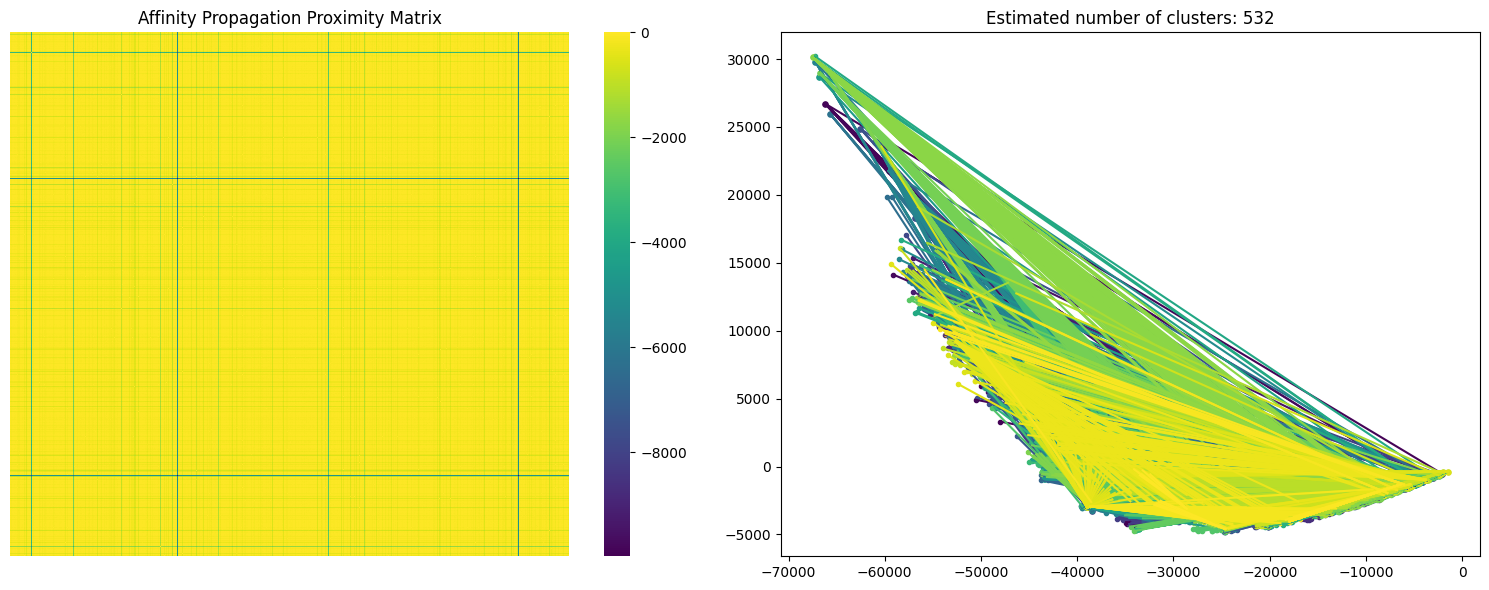

In [58]:
### Visualisation
figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

### Visualization: proximity matrix
sns.heatmap(affinity_propagation.affinity_matrix_, cmap="viridis", xticklabels=False, yticklabels=False, ax=axis[0])
axis[0].set_title("Affinity Propagation Proximity Matrix")

### Visualize the clusters
unique_labels = np.unique(predicted_labels)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))

for k, col in zip(range(n_clusters_), colors):
    class_members = predicted_labels == k
    cluster_center = embedding_matrix[cluster_centers_indices[k]]
    plt.scatter(embedding_matrix[class_members, 0], embedding_matrix[class_members, 1], color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in embedding_matrix[class_members]:
        axis[1].plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

axis[1].set_title("Estimated number of clusters: %d" % n_clusters_)
plt.tight_layout()
plt.show()

## Part 2: Experimenting with Hyperparameters, Embedding Dimensions and Normalizations.

### **Experimenting with Hyperparameters**:

In this section we try different values for doing the Smith Waterman alignment between two sequences. We change the below parameters:

1.   Match Score: The score given when a letter/unit of first sequence matches with the unit of second sequence.
2.   Mismatch Score: The negative score given when there is mismatch between the letter/unit of the sequences.
3.   Gap Penalty: Gap penalty is subtracted for each gap that has been introduced. There are different gap penalties such as gap open and gap extension.

We observe that when we change the these hyperparameters, the similarity matrix changes as well. Also, when we keep the match score high or the mismatch score low, we get a better alignment score.



In [49]:
### Experiment with different Smith-Waterman alignment hyperparameters
match_score = 3
mismatch_penalty = -2
gap_open_penalty = -3
gap_extend_penalty = -1
similarity_matrix1 = np.zeros((num_sequences,num_sequences))

### Similarity Matrix
for i in tqdm(range(num_sequences)):
    for j in range(i, num_sequences):
        seq1 = seq5k_asc[i].seq
        seq2 = seq5k_asc[j].seq

        ### Trying different hyperparameters
        alignment_score = smith_waterman_alignment_score(seq1, seq2, match_score, mismatch_penalty, gap_open_penalty, gap_extend_penalty)
        similarity_matrix1[i][j] = similarity_matrix1[j][i] = alignment_score

print(similarity_matrix1)


100%|██████████| 5000/5000 [1:49:48<00:00,  1.32s/it] 

[[144.  13.   9. ...   9.  10.   8.]
 [ 13. 240.   7. ...   9.   8.   9.]
 [  9.   7. 135. ...   6.   8.   7.]
 ...
 [  9.   9.   6. ... 129.   7.   7.]
 [ 10.   8.   8. ...   7. 414.  10.]
 [  8.   9.   7. ...   7.  10. 228.]]


### **Experimenting with Embedding Dimensions and Normalization:**
**Embedding Dimensions:**
In this section, we try different embedding options by changing the number of dimensions. We use 50, 100 and 150 top eigenvectors for the embedding.

**Normalization:**
Here, we normalize the obtained embedded_vectors and apply Affinity Propagation to cluster the data. We experiment with the following normalization options:

1.   No Normalization
2.   StandardScalar: Standardize features by removing the mean and scaling to unit variance.

3.   MinMaxScalar: Transform features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.


Finally we plot heatmaps for all the experimentation results.

RESULTS:

We observe that the NMI score is highest for the following options:

*Embedding Dimension: 100, Normalization: StandardScaler(), NMI: 0.5125387752830188*



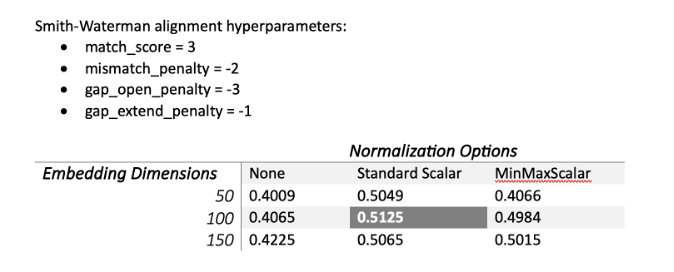


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 50, Normalization: None, NMI: 0.4009758483092986


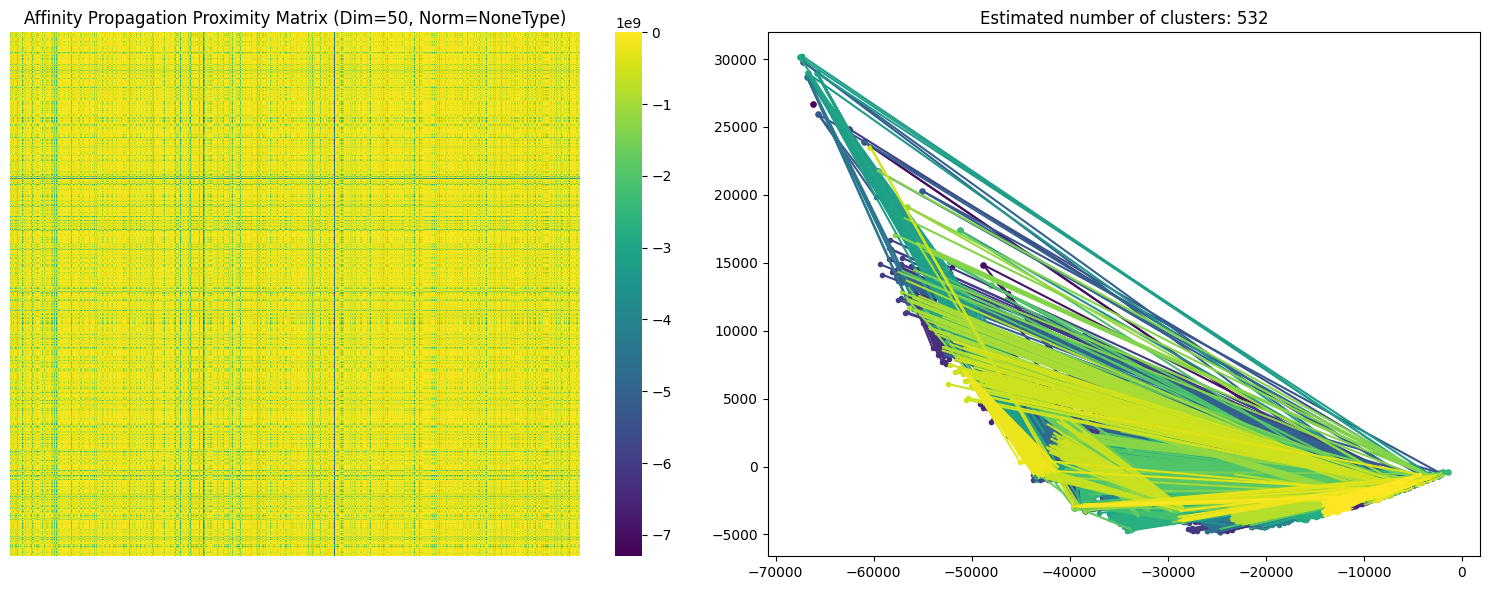

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 50, Normalization: StandardScaler(), NMI: 0.504988617444719


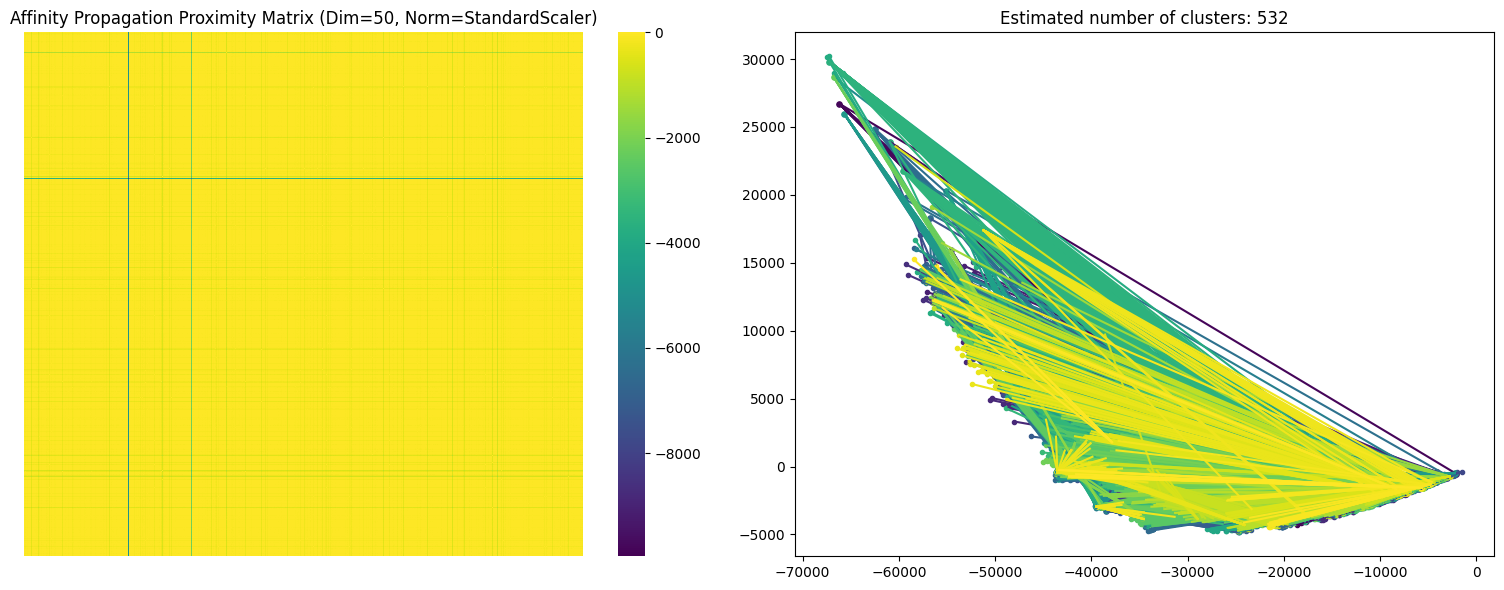

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 50, Normalization: MinMaxScaler(), NMI: 0.4606292106489297


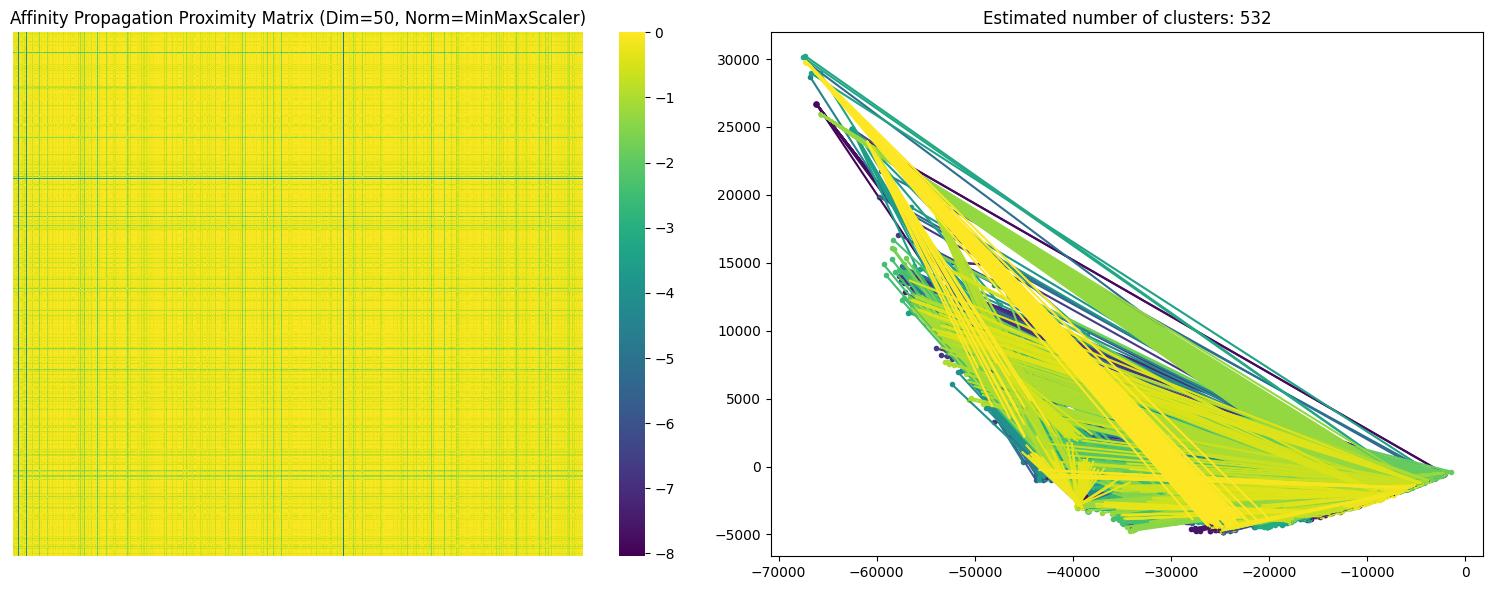

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 100, Normalization: None, NMI: 0.40657448927142953


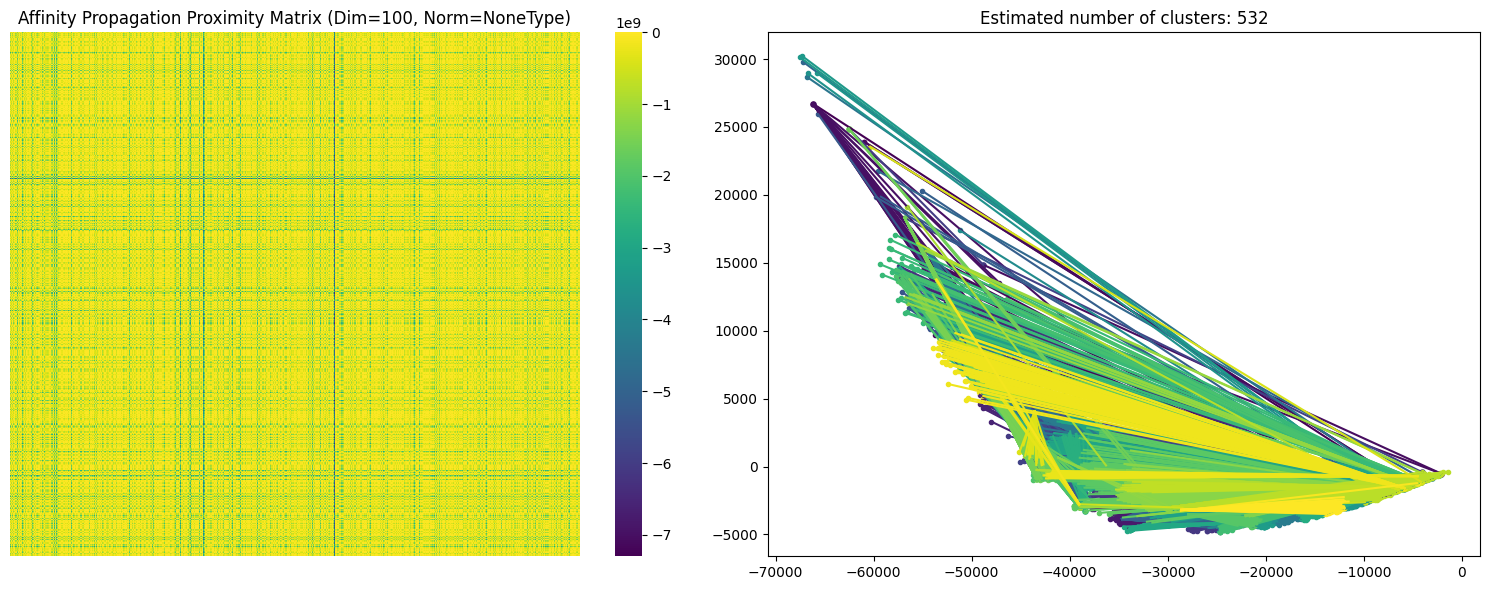

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 100, Normalization: StandardScaler(), NMI: 0.5125387752830188


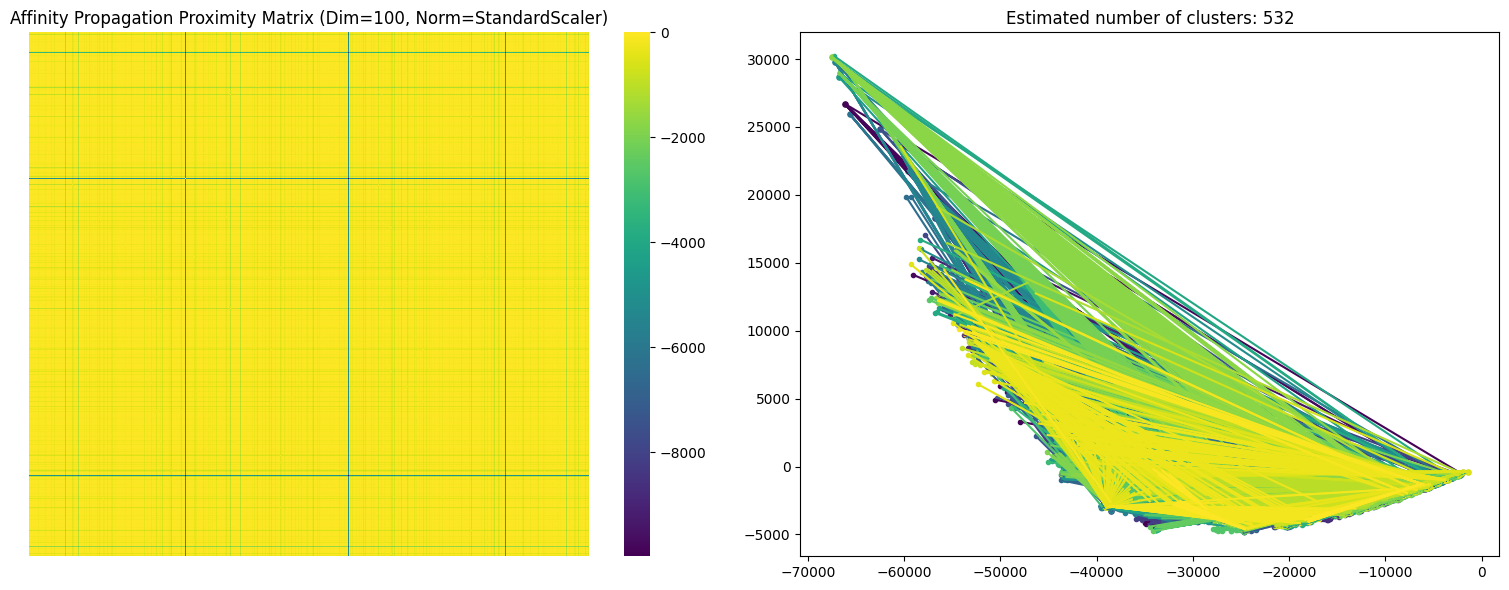

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 100, Normalization: MinMaxScaler(), NMI: 0.498413835810668


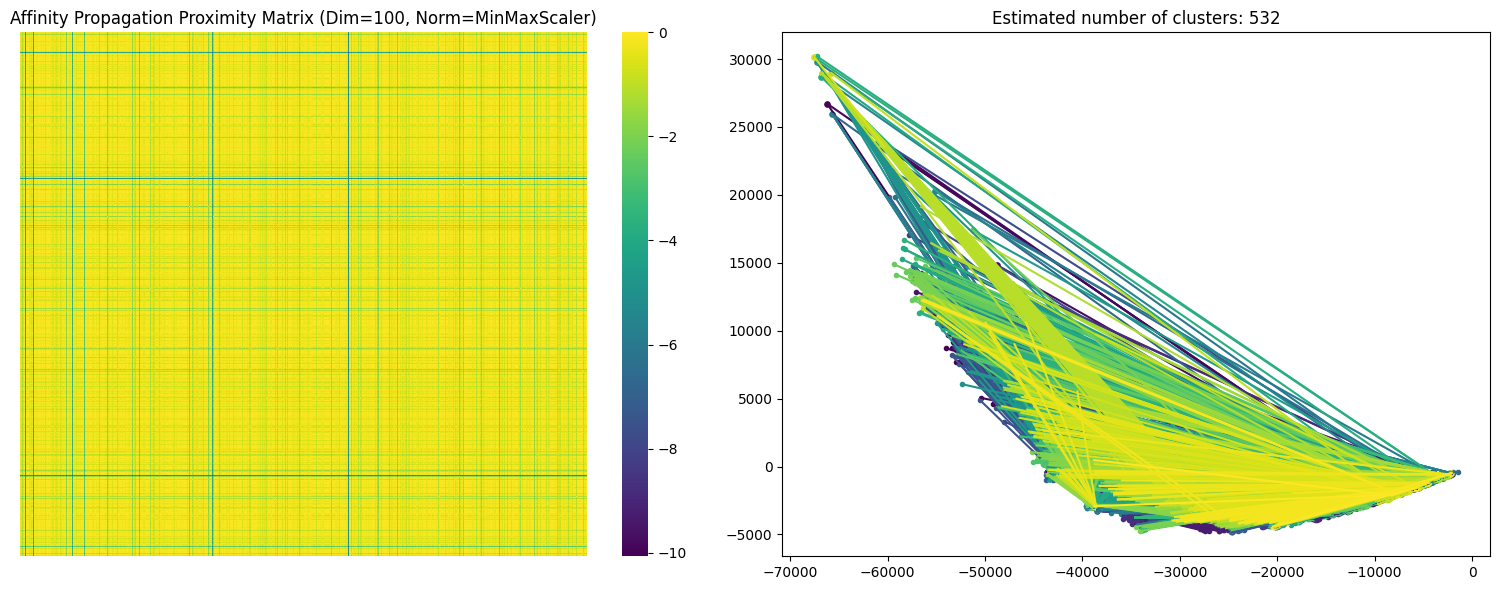

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 150, Normalization: None, NMI: 0.422573946333434


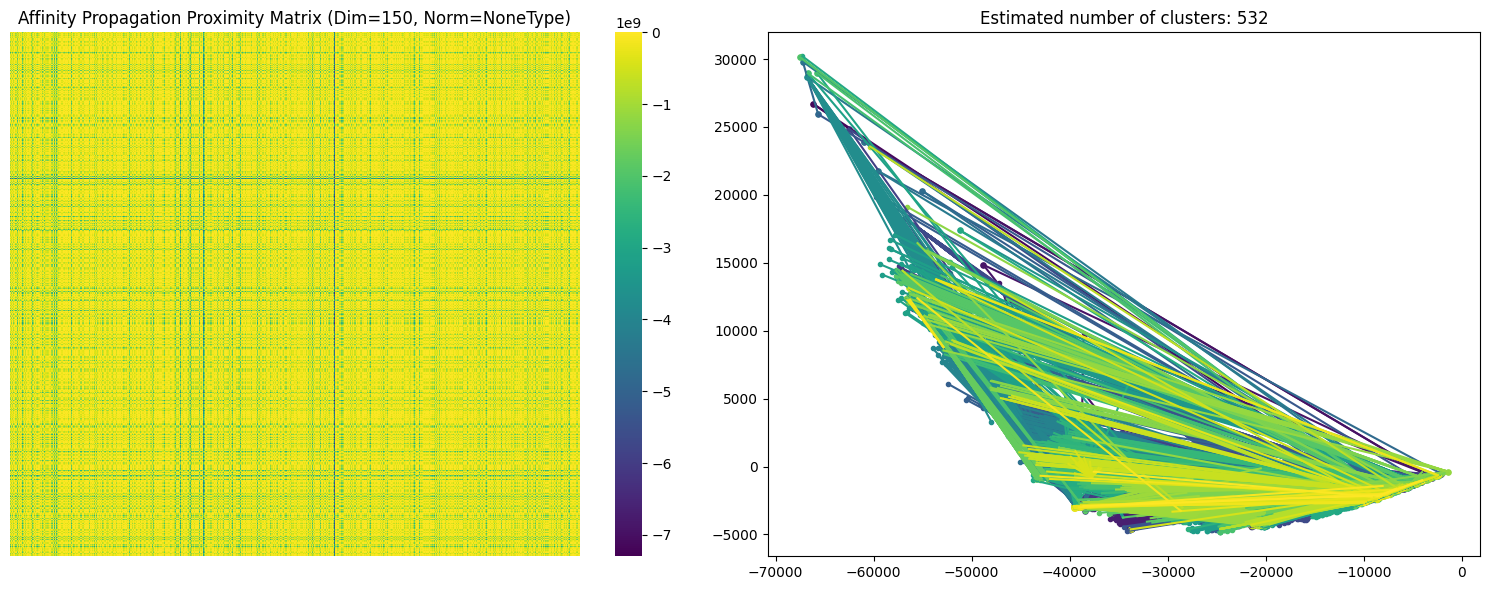

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 150, Normalization: StandardScaler(), NMI: 0.5065027718760241


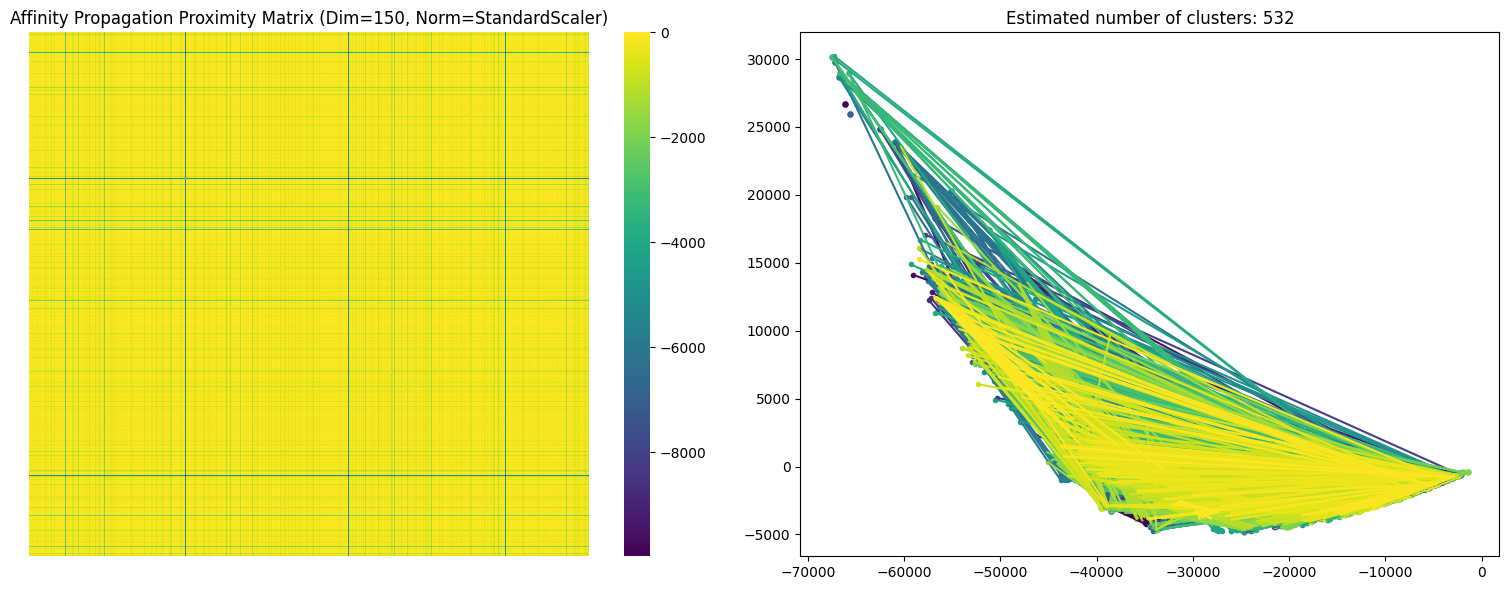

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(





Embedding Dimension: 150, Normalization: MinMaxScaler(), NMI: 0.501536090369853


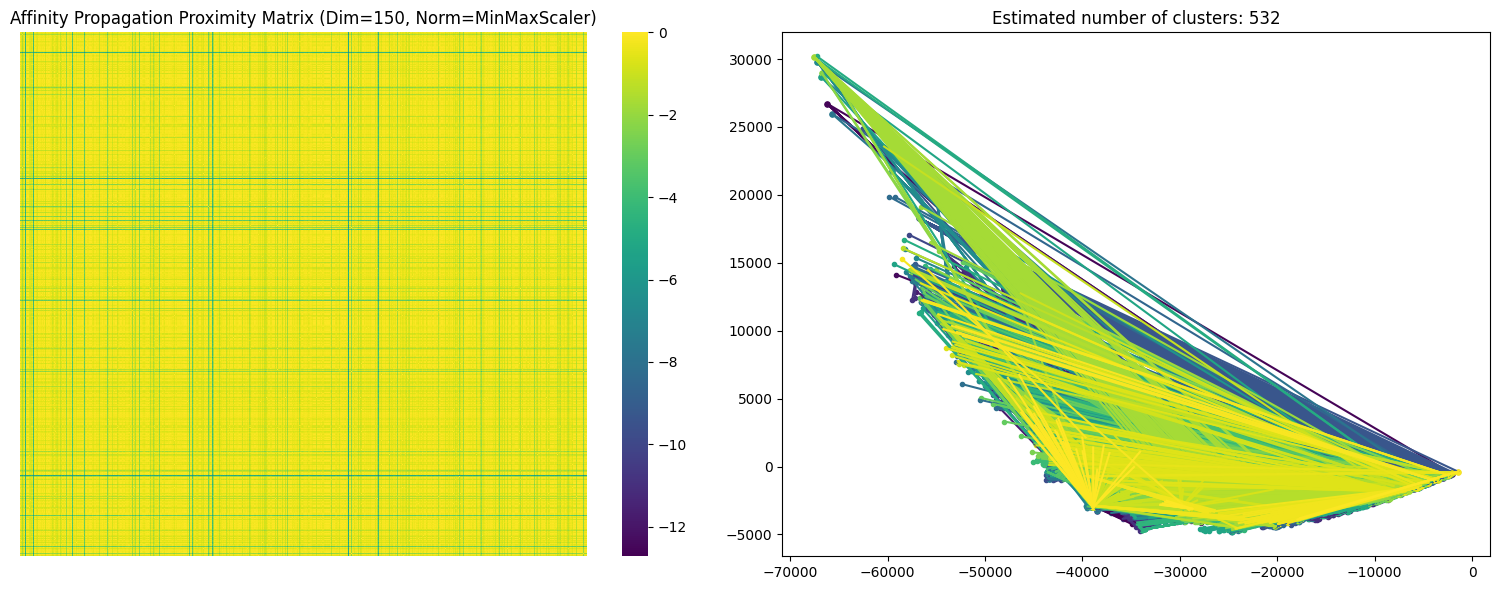

In [61]:
### Experimenting with different embedding dimensions
embedding_dimensions = [50, 100, 150]

### Experimenting with different normalization methods
normalization_options = [None, StandardScaler(), MinMaxScaler()]

for embedding_dim in embedding_dimensions:

    ### Get Embedding
    embedded_vectors = get_embedding(similarity_matrix, num_dimensions=embedding_dim)


    for normalization_method in normalization_options:
        if normalization_method:
            ### Normalization
            embedded_vectors = normalization_method.fit_transform(embedded_vectors)

        ### Cluster the data using Affinity Propagation
        affinity_propagation = AffinityPropagation(random_state=42)
        predicted_labels = affinity_propagation.fit_predict(embedded_vectors)

        ### Ground Truth labels
        true_labels = get_ground_truth_labels(seq5k_asc)
        nmi_score = calculate_nmi(true_labels, predicted_labels)

        ### Results
        print(f"\n\n\nEmbedding Dimension: {embedding_dim}, Normalization: {normalization_method}, NMI: {nmi_score}")

        ### Visualisation
        figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        ### Visualization: proximity matrix
        sns.heatmap(affinity_propagation.affinity_matrix_, cmap="viridis", xticklabels=False, yticklabels=False,ax=axis[0])
        axis[0].set_title(f"Affinity Propagation Proximity Matrix (Dim={embedding_dim}, Norm={normalization_method.__class__.__name__})")

        ### Visualize the clusters
        unique_labels = np.unique(predicted_labels)
        colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, len(unique_labels))))

        for k, col in zip(range(n_clusters_), colors):
            class_members = predicted_labels == k
            cluster_center = embedding_matrix[cluster_centers_indices[k]]
            plt.scatter(embedding_matrix[class_members, 0], embedding_matrix[class_members, 1], color=col["color"], marker=".")
            plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
            for x in embedding_matrix[class_members]:
                axis[1].plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])

        axis[1].set_title("Estimated number of clusters: %d" % n_clusters_)
        plt.tight_layout()
        plt.show()
        print("\n\n\n")
